<a href="https://colab.research.google.com/github/trainsn/cuda-learning/blob/master/udacity_cs344_hw6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Homework 6 for Udacity CS344 Course, Intro to Parallel Programming
# clone the code repo,
!git clone https://github.com/depctg/udacity-cs344-colab
!pip install git+git://github.com/depctg/nvcc4jupyter.git

# load cuda plugin
%config NVCCPluginV2.static_dir = True
%config NVCCPluginV2.relative_dir = "udacity-cs344-colab/src/HW6"
%load_ext nvcc_plugin

# change to work directory, generate makefiles
!mkdir udacity-cs344-colab/build
%cd udacity-cs344-colab/build
!cmake ../src

Cloning into 'udacity-cs344-colab'...
remote: Enumerating objects: 144, done.
remote: Total 144 (delta 0), reused 0 (delta 0), pack-reused 144
Receiving objects: 100% (144/144), 3.93 MiB | 2.77 MiB/s, done.
Resolving deltas: 100% (43/43), done.
  Cloning git://github.com/depctg/nvcc4jupyter.git to /tmp/pip-req-build-qoiqvxbd
  Running command git clone -q git://github.com/depctg/nvcc4jupyter.git /tmp/pip-req-build-qoiqvxbd
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-cp36-none-any.whl size=4334 sha256=149606df381bb96f8eb1cffb0970aa8f0ff05de8ddb8b32cb298b80a9f5b026e
  Stored in directory: /tmp/pip-ephem-wheel-cache-knb_pp5e/wheels/1e/43/2d/099cad2b9b02dfa88573f50a22735d8a0b2ba69bf82167b81c
Successfully built NVCCPlugin
Set up cuda environment at /content/udacity-cs344-colab/src/HW6
Default out bin result.out
/content/udacity-cs344-colab/build
-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Check for working C compiler: /usr/b

In [0]:
%%cuda --name student_func.cu

//Udacity HW 6
//Poisson Blending

/* Background
   ==========
   The goal for this assignment is to take one image (the source) and
   paste it into another image (the destination) attempting to match the
   two images so that the pasting is non-obvious. This is
   known as a "seamless clone".
   The basic ideas are as follows:
   1) Figure out the interior and border of the source image
   2) Use the values of the border pixels in the destination image 
      as boundary conditions for solving a Poisson equation that tells
      us how to blend the images.
   
      No pixels from the destination except pixels on the border
      are used to compute the match.
   Solving the Poisson Equation
   ============================
   There are multiple ways to solve this equation - we choose an iterative
   method - specifically the Jacobi method. Iterative methods start with
   a guess of the solution and then iterate to try and improve the guess
   until it stops changing.  If the problem was well-suited for the method
   then it will stop and where it stops will be the solution.
   The Jacobi method is the simplest iterative method and converges slowly - 
   that is we need a lot of iterations to get to the answer, but it is the
   easiest method to write.
   Jacobi Iterations
   =================
   Our initial guess is going to be the source image itself.  This is a pretty
   good guess for what the blended image will look like and it means that
   we won't have to do as many iterations compared to if we had started far
   from the final solution.
   ImageGuess_prev (Floating point)
   ImageGuess_next (Floating point)
   DestinationImg
   SourceImg
   Follow these steps to implement one iteration:
   1) For every pixel p in the interior, compute two sums over the four neighboring pixels:
      Sum1: If the neighbor is in the interior then += ImageGuess_prev[neighbor]
             else if the neighbor in on the border then += DestinationImg[neighbor]
      Sum2: += SourceImg[p] - SourceImg[neighbor]   (for all four neighbors)
   2) Calculate the new pixel value:
      float newVal= (Sum1 + Sum2) / 4.f  <------ Notice that the result is FLOATING POINT
      ImageGuess_next[p] = min(255, max(0, newVal)); //clamp to [0, 255]
    In this assignment we will do 800 iterations.
   */
   
#include "utils.h"
#include <algorithm>

// get 2d position from block
__device__
int2 get2dPos() { 
	return make_int2(
		blockIdx.x * blockDim.x + threadIdx.x,
       	blockIdx.y * blockDim.y + threadIdx.y
	);
}

// check whether a a value is within the image bounds
__device__
bool withinBounds(const int x, const int y, const size_t numRowsSource, const size_t numColsSource) {
    return ((x < numColsSource) && (y < numRowsSource));
}

__device__
bool masked(uchar4 val) {
	return (val.x != 255 || val.y != 255 || val.z != 255);
}

__device__
int getm(int x, int y, size_t numColsSource) {
	return y*numColsSource + x;
}

__global__
void maskPredicateKernel(
	const uchar4* const d_sourceImg,
	int* d_borderPredicate,
	int* d_interiorPredicate,
	const size_t numRowsSource,
	const size_t numColsSource) {
	
    const int2 p = get2dPos();
	const int  m = getm(p.x, p.y, numColsSource);
    
    if(!withinBounds(p.x, p.y, numRowsSource, numColsSource))
         return;

 	// run through each pixel and determine if its 
	// on the border, or if its on the interior border
	
	if(masked(d_sourceImg[m])) {
		int inbounds = 0;
		int interior = 0;

		// count how many of our neighbors are masked,
		// and how many neighbors we have
		if (withinBounds(p.x, p.y+1, numRowsSource, numColsSource)) {
			inbounds++;
			if(masked(d_sourceImg[getm(p.x, p.y+1, numColsSource)]))
				interior++;		
	
		}
		if (withinBounds(p.x, p.y-1, numRowsSource, numColsSource)) {
			inbounds++;
			if(masked(d_sourceImg[getm(p.x, p.y-1, numColsSource)]))
				interior++;		
	
		}
		if (withinBounds(p.x+1, p.y, numRowsSource, numColsSource)) {
			inbounds++;
			if(masked(d_sourceImg[getm(p.x+1, p.y, numColsSource)]))
				interior++;		
		}
		if (withinBounds(p.x-1, p.y, numRowsSource, numColsSource)) {
			inbounds++;
			if(masked(d_sourceImg[getm(p.x-1, p.y, numColsSource)]))
				interior++;		
		}

		// clear out the values so we don't
		// have to memset this destination stuff
		d_interiorPredicate[m] = 0;
		d_borderPredicate[m]   = 0;
	
		// if all our neighbors are masked, then its interior
		if(inbounds == interior) {
			d_interiorPredicate[m] = 1;
		} else if (interior > 0) {
			d_borderPredicate[m] = 1;
		}
	}
}

__global__
void separateChannelsKernel(
	const uchar4* const inputImageRGBA,
	float* const redChannel,
	float* const greenChannel,
	float* const blueChannel,
	size_t numRows,
	size_t numCols)
{
    const int2 p = get2dPos();
	const int  m = getm(p.x, p.y, numCols);
    
    if(!withinBounds(p.x, p.y, numRows, numCols))
         return;

  	redChannel[m]   = (float)inputImageRGBA[m].x;
  	greenChannel[m] = (float)inputImageRGBA[m].y;
  	blueChannel[m]  = (float)inputImageRGBA[m].z;
}

__global__
void recombineChannelsKernel(
	uchar4* outputImageRGBA,
	float* const redChannel,
	float* const greenChannel,
	float* const blueChannel,
	size_t numRows,
	size_t numCols)
{
    const int2 p = get2dPos();
	const int  m = getm(p.x, p.y, numCols);
    
    if(!withinBounds(p.x, p.y, numRows, numCols))
         return;
	
	outputImageRGBA[m].x = (char)redChannel[m];
	outputImageRGBA[m].y = (char)greenChannel[m];
	outputImageRGBA[m].z = (char)blueChannel[m];
}

__global__
void jacobiKernel(
	float* d_in,
	float* d_out,
	const int* d_borderPredicate,
	const int* d_interiorPredicate,
	float* d_source,
	float* d_dest,
	size_t numRows,
	size_t numCols)
{
    const int2 p = get2dPos();
	const int  m = getm(p.x, p.y, numCols);
    
    if(!withinBounds(p.x, p.y, numRows, numCols))
         return;

	// calculate these values as indicated in the videos

	int lm;
	if(d_interiorPredicate[m]==1) {
		float a = 0.f, b=0.f, c=0.0f, d=0.f;
		float sourceVal = d_source[m];

		if(withinBounds(p.x, p.y+1, numRows, numCols)) {
			d++;
			lm = getm(p.x, p.y+1, numCols);
			if(d_interiorPredicate[lm]==1) {
				a += d_in[lm];
			} else if(d_borderPredicate[lm]==1) {
				b += d_dest[lm];
			}
			c += (sourceVal-d_source[lm]);
		}
		
		if(withinBounds(p.x, p.y-1, numRows, numCols)) {
			d++;
			lm = getm(p.x, p.y-1, numCols);
			if(d_interiorPredicate[lm]==1) {
				a += d_in[lm];
			} else if(d_borderPredicate[lm]==1) {
				b += d_dest[lm];
			}
			c += (sourceVal-d_source[lm]);
		}
		
		if(withinBounds(p.x+1, p.y, numRows, numCols)) {
			d++;
			lm = getm(p.x+1, p.y, numCols);
			if(d_interiorPredicate[lm]==1) {
				a += d_in[lm];
			} else if(d_borderPredicate[lm]==1) {
				b += d_dest[lm];
			}
			c += (sourceVal-d_source[lm]);
		}
		
		if(withinBounds(p.x-1, p.y, numRows, numCols)) {
			d++;
			lm = getm(p.x-1, p.y, numCols);
			if(d_interiorPredicate[lm]==1) {
				a += d_in[lm];
			} else if(d_borderPredicate[lm]==1) {
				b += d_dest[lm];
			}
			c += (sourceVal-d_source[lm]);
		}
		
		d_out[m] = min(255.f, max(0.0, (a + b + c)/d));
	} else {
		d_out[m] = d_dest[m];
	}
	
}

void your_blend(const uchar4* const h_sourceImg,  //IN
                const size_t numRowsSource, const size_t numColsSource,
                const uchar4* const h_destImg, //IN
                uchar4* const h_blendedImg) //OUT
{
	// first push the dest and source onto the gpu
	size_t imageSize = numRowsSource*numColsSource*sizeof(uchar4);
	
	uchar4* d_sourceImg;
	uchar4* d_destImg;
	uchar4* d_finalImg;

	checkCudaErrors(cudaMalloc(&d_sourceImg, imageSize));
	checkCudaErrors(cudaMalloc(&d_destImg, 	 imageSize));
	checkCudaErrors(cudaMalloc(&d_finalImg,  imageSize));

  	checkCudaErrors(cudaMemcpy(d_sourceImg, h_sourceImg, imageSize, cudaMemcpyHostToDevice));
  	checkCudaErrors(cudaMemcpy(d_destImg, 	h_destImg, 	 imageSize, cudaMemcpyHostToDevice));

	// allocate predicate stuff
	size_t predicateSize = numRowsSource*numColsSource*sizeof(int);
	int* d_borderPredicate;
	int* d_interiorPredicate;

	checkCudaErrors(cudaMalloc(&d_borderPredicate, 	 predicateSize));
	checkCudaErrors(cudaMalloc(&d_interiorPredicate, predicateSize));

	// make reusable dims
	const dim3 blockSize(32, 32);
    const dim3 gridSize(numColsSource/blockSize.x + 1, numRowsSource/blockSize.y + 1);


	/**
     1) Compute a mask of the pixels from the source image to be copied
        The pixels that shouldn't be copied are completely white, they
        have R=255, G=255, B=255.  Any other pixels SHOULD be copied.
	**/

	/**
     2) Compute the interior and border regions of the mask.  An interior
        pixel has all 4 neighbors also inside the mask.  A border pixel is
        in the mask itself, but has at least one neighbor that isn't.
	**/

	// generate the predicates
	maskPredicateKernel<<<gridSize, blockSize>>>(
		d_sourceImg,
		d_borderPredicate,
		d_interiorPredicate,
		numRowsSource,
		numColsSource
	);

 	cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

 	/**
     3) Separate out the incoming image into three separate channels
	**/
	size_t floatSize = numRowsSource*numColsSource*sizeof(float);
	float *d_sourceImgR, *d_sourceImgG, *d_sourceImgB; 
	float *d_destImgR,   *d_destImgG, 	*d_destImgB;

	checkCudaErrors(cudaMalloc(&d_sourceImgR, floatSize));
	checkCudaErrors(cudaMalloc(&d_sourceImgG, floatSize));
	checkCudaErrors(cudaMalloc(&d_sourceImgB, floatSize));
	
	checkCudaErrors(cudaMalloc(&d_destImgR, floatSize));
	checkCudaErrors(cudaMalloc(&d_destImgG, floatSize));
	checkCudaErrors(cudaMalloc(&d_destImgB, floatSize));
	
	separateChannelsKernel<<<gridSize, blockSize>>>(
		d_sourceImg,
		d_sourceImgR,
		d_sourceImgG,
		d_sourceImgB,
		numRowsSource,
		numColsSource);

 	cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

	separateChannelsKernel<<<gridSize, blockSize>>>(
		d_destImg,
		d_destImgR,
		d_destImgG,
		d_destImgB,
		numRowsSource,
		numColsSource);

 	cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

	/** 
     4) Create two float(!) buffers for each color channel that will
        act as our guesses.  Initialize them to the respective color
        channel of the source image since that will act as our intial guess.
	**/
	
	// allocate floats
	float *d_r0, *d_r1, *d_g0, *d_g1, *d_b0, *d_b1; 
	checkCudaErrors(cudaMalloc(&d_r0, floatSize));
	checkCudaErrors(cudaMalloc(&d_r1, floatSize));
	checkCudaErrors(cudaMalloc(&d_b0, floatSize));
	checkCudaErrors(cudaMalloc(&d_b1, floatSize));
	checkCudaErrors(cudaMalloc(&d_g0, floatSize));
	checkCudaErrors(cudaMalloc(&d_g1, floatSize));


  	checkCudaErrors(cudaMemcpy(d_r0, d_sourceImgR, floatSize, cudaMemcpyDeviceToDevice));
  	checkCudaErrors(cudaMemcpy(d_g0, d_sourceImgG, floatSize, cudaMemcpyDeviceToDevice));
  	checkCudaErrors(cudaMemcpy(d_b0, d_sourceImgB, floatSize, cudaMemcpyDeviceToDevice));

 	cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

	/**
     5) For each color channel perform the Jacobi iteration described 
        above 800 times.
	**/
	for(int i = 0; i < 800; i++) {
		jacobiKernel<<<gridSize, blockSize>>>(
			d_r0, 
			d_r1,
			d_borderPredicate,
			d_interiorPredicate,
			d_sourceImgR,
			d_destImgR,
			numRowsSource,
			numColsSource
		);
		std::swap(d_r0, d_r1);

		jacobiKernel<<<gridSize, blockSize>>>(
			d_g0, 
			d_g1,
			d_borderPredicate,
			d_interiorPredicate,
			d_sourceImgG,
			d_destImgG,
			numRowsSource,
			numColsSource
		);
		std::swap(d_g0, d_g1);

		jacobiKernel<<<gridSize, blockSize>>>(
			d_b0, 
			d_b1,
			d_borderPredicate,
			d_interiorPredicate,
			d_sourceImgB,
			d_destImgB,
			numRowsSource,
			numColsSource
		);
		std::swap(d_b0, d_b1);
	}

	/**
     6) Create the output image by replacing all the interior pixels
        in the destination image with the result of the Jacobi iterations.
        Just cast the floating point values to unsigned chars since we have
        already made sure to clamp them to the correct range.
	**/

	// lets assume that d_r0, d_g0, d_b0 are the final pass
	recombineChannelsKernel<<<gridSize, blockSize>>>(
		d_finalImg,
		d_r0,
		d_g0,
		d_b0,
		numRowsSource,
		numColsSource);

 	cudaDeviceSynchronize(); checkCudaErrors(cudaGetLastError());

	// copy device final image to host
  	checkCudaErrors(cudaMemcpy(h_blendedImg, d_finalImg, imageSize, cudaMemcpyDeviceToHost));

	// cleanup
  	checkCudaErrors(cudaFree(d_sourceImg));
  	checkCudaErrors(cudaFree(d_destImg));
	checkCudaErrors(cudaFree(d_finalImg));

	checkCudaErrors(cudaFree(d_sourceImgR));
	checkCudaErrors(cudaFree(d_sourceImgG));
	checkCudaErrors(cudaFree(d_sourceImgB));

	checkCudaErrors(cudaFree(d_destImgR));
	checkCudaErrors(cudaFree(d_destImgG));
	checkCudaErrors(cudaFree(d_destImgB));

	checkCudaErrors(cudaFree(d_r0));
	checkCudaErrors(cudaFree(d_r1));
	checkCudaErrors(cudaFree(d_g0));
	checkCudaErrors(cudaFree(d_g1));
	checkCudaErrors(cudaFree(d_b0));
	checkCudaErrors(cudaFree(d_b1));
}

'File written in /content/udacity-cs344-colab/src/HW6/student_func.cu'

In [0]:
# make the cuda project
!make HW6
print("\n====== RESULT OF HW6 =======\n")
!bin/HW6 ../src/HW6/source.png ../src/HW6/blended.gold

[ 14%] Building NVCC (Device) object HW6/CMakeFiles/HW6.dir/HW6_generated_student_func.cu.o
Scanning dependencies of target HW6
[ 28%] Building CXX object HW6/CMakeFiles/HW6.dir/main.cpp.o
[ 42%] Building CXX object HW6/CMakeFiles/HW6.dir/loadSaveImage.cpp.o
[ 57%] Building CXX object HW6/CMakeFiles/HW6.dir/reference_calc.cpp.o
[ 71%] Building CXX object HW6/CMakeFiles/HW6.dir/compare.cpp.o
[ 85%] Linking CXX executable ../bin/HW6
[100%] Built target HW6

====== RESULT OF HW6 =======

Your code ran in: 257.506500 msecs.

PASS


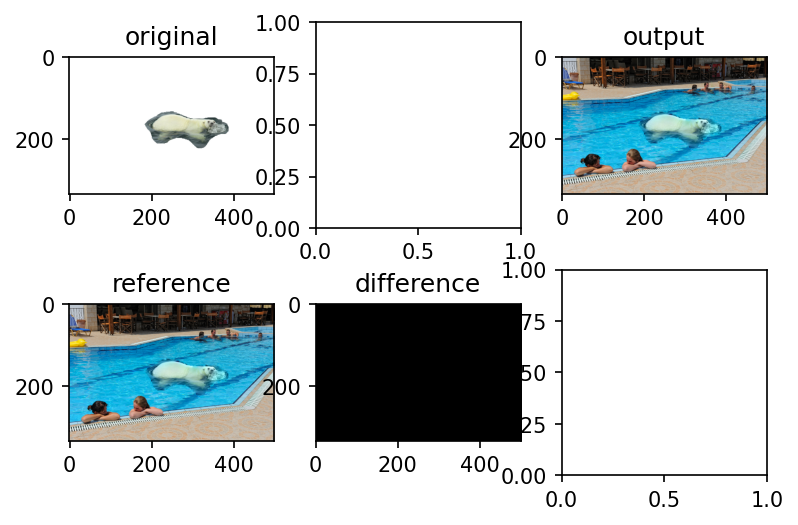

In [0]:
# plot output images
import matplotlib.pyplot as plt
_,ax = plt.subplots(2,3, dpi=150)

ax[0][0].imshow(plt.imread("../src/HW6/source.png"))
ax[0][0].set_title("original")
ax[0][0].grid(False)

ax[0][2].imshow(plt.imread("HW6_output.png"))
ax[0][2].set_title("output")
ax[0][2].grid(False)

ax[1][0].imshow(plt.imread("HW6_reference.png"))
ax[1][0].set_title("reference")
ax[1][0].grid(False)

ax[1][1].imshow(plt.imread("HW6_differenceImage.png"))
ax[1][1].set_title("difference")
ax[1][1].grid(False)

plt.show()